In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from conformal_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Inputs
1. Class-specific qhats
2. Conformal scores (e.g., softmax vectors) and ground truth labels to evaluate on 

In [49]:
qhats = np.load('.cache/quantiles_06-08-22.npy') # qhats estimated using oracle prior

In [22]:
# qhats_old = np.load('.cache/quantiles_06-02-22.npy') # messed up qhats that switched softmax and 1-softmax

In [50]:
qhats

array([0.892691  , 0.96158587, 0.98572446, 0.9812934 , 0.98181163,
       0.99416356, 0.97768944, 0.99223261, 0.98411883, 0.83389078,
       0.91399732, 0.92164012, 0.98277134, 0.96003558, 0.92146319,
       0.90779244, 0.89700984, 0.87886161, 0.97409526, 0.94826642,
       0.96581401, 0.94976646, 0.90863292, 0.95302781, 0.79943146,
       0.99314568, 0.98507472, 0.97785348, 0.94306061, 0.93575642,
       0.96194235, 0.99020021, 0.96511262, 0.98325587, 0.99863174,
       0.99179097, 0.99859864, 0.94672638, 0.99083562, 0.96691105,
       0.97705835, 0.94982093, 0.95733696, 0.99309698, 0.99509524,
       0.92884617, 0.99111028, 0.93630998, 0.93749459, 0.99026585,
       0.97096321, 0.79790425, 0.99123886, 0.98345316, 0.99626202,
       0.99827646, 0.96614657, 0.97827529, 0.98666376, 0.99122958,
       0.99535558, 0.97575003, 0.99950002, 0.94385616, 0.9806834 ,
       0.98246941, 0.9999255 , 0.99097413, 0.99641147, 0.97936353,
       0.9162958 , 0.95109877, 0.97010071, 0.99998462, 0.99912

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   5.,   8.,   6.,   5.,   9.,   2.,   8.,   8.,   8.,  13.,
         14.,   8.,  15.,  23.,  24.,  29.,  34.,  52.,  85., 136., 507.]),
 array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24

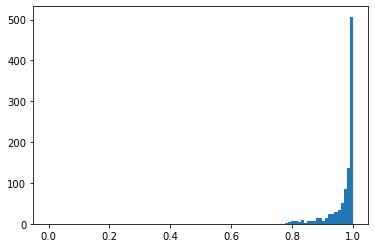

In [68]:
plt.hist(qhats, bins=np.linspace(0,1,100))

In [8]:
# Load data 
softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
softmax_scores = softmax_scores.numpy()
labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
labels = labels.type(torch.LongTensor).numpy()

In [25]:
scores = 1 - softmax_scores

In [26]:
%%time
# Get split of data not used for calibration
_, _, val_scores, val_labels = split_X_and_y(scores, labels, 20, num_classes=1000, seed=0)

CPU times: user 3.43 s, sys: 2min 1s, total: 2min 4s
Wall time: 2min 5s


### Evaluate

In [60]:
preds = create_cb_prediction_sets(val_scores, qhats)
# cb_preds = create_cb_prediction_sets(scores, qhats_old)

In [61]:
marginal_cov = compute_coverage(val_labels, preds)
print(f'Marginal coverage: {cb_marginal_cov*100:.2f}%')

Marginal coverage: 3.88%


In [62]:
class_specific_cov = compute_class_specific_coverage(val_labels, preds)

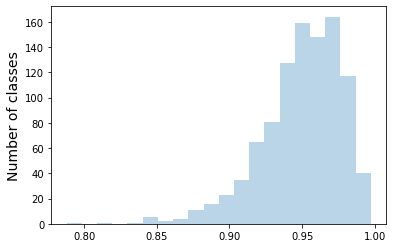

In [63]:
plt.hist(class_specific_cov, bins=20, label="Empirical Bayes class-balanced", alpha=.3)
plt.ylabel('Number of classes', fontsize=14)

plt.show()

In [64]:
# Compute number of classes that are drastically undercovered (<80%)
num_undercovered = np.sum(class_specific_cov < 0.8)
print(f'Number of classes that have less than 80% coverage:', num_undercovered)

Number of classes that have less than 80% coverage: 1


In [65]:
avg_set_size = compute_avg_set_size(preds)
print(f'\nAverage size of Empirical Bayes conformal set: {avg_set_size:.2f}')


Average size of Empirical Bayes conformal set: 10.46


In [58]:
preds[:10]

[array([ 73, 311, 312, 784]),
 array([118, 122, 175, 208, 463, 593, 618, 631, 659, 664, 673, 696, 700,
        710, 731, 778, 813, 898, 899, 909, 910, 923, 924, 928, 934, 935,
        937, 938, 943, 959, 966, 987, 995, 998]),
 array([446, 478, 519, 692, 710, 811, 921, 966]),
 array([12]),
 array([277, 278]),
 array([ 73, 122]),
 array([ 80,  81,  82,  86, 899]),
 array([435, 618, 673, 700, 731, 794, 804, 813, 861, 896, 897, 999]),
 array([  3,  66, 171, 173, 224, 405, 421, 463, 488, 497, 499, 557, 593,
        618, 631, 632, 664, 673, 696, 698, 700, 701, 709, 710, 718, 733,
        737, 756, 784, 792, 794, 797, 811, 813, 836, 838, 868, 876, 879,
        885, 893, 899, 904, 908, 910, 913, 919, 928, 968, 973, 975, 998]),
 array([501, 524, 578, 593, 601, 618, 643, 689, 773, 784, 794, 797, 849,
        887, 899, 901])]

In [59]:
val_labels[:10]

array([311, 121, 478,  12, 278, 122,  81, 861, 879, 887])